*   This is to support part V.B.ii in our paper
*   We factor sentiment element into Tweets and then visualize the relationship between Amazon stock price and Tweets

In [ ]:
%matplotlib inline 

import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 6

In [ ]:
#Use dataframe that we exported from coding file "V_A_Tweet_Sentiment_Analysis" and stock price data from Kaggle
Microsoft = pd.read_csv('Microsoft.csv')
company_value = pd.read_csv('CompanyValues.csv')
company_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.09
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.50
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.35


In [ ]:
#Add column of daily returns into the stock price table
company_value['returns'] = company_value.sort_values('day_date').groupby(['ticker_symbol']).close_value.pct_change()
Microsoft_value = company_value[company_value['ticker_symbol'] == 'MSFT'].sort_values('day_date')
Microsoft_value.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,returns
13894,MSFT,2010-06-01,25.89,76120800,25.53,26.31,25.52,NaN
13893,MSFT,2010-06-02,26.46,65259520,26.06,26.48,25.73,0.022016
13892,MSFT,2010-06-03,26.86,67797970,26.55,26.93,26.41,0.015117
13891,MSFT,2010-06-04,25.79,89508290,26.10,26.57,25.62,-0.039836
13890,MSFT,2010-06-07,25.29,80327890,25.82,25.83,25.24,-0.019387


In [ ]:
#Merge Tweets content and stock price dataframe
Microsoft_tweet_vs_value =  pd.merge(Microsoft, Microsoft_value, left_on=['post_date'], right_on = ['day_date'], how= "inner")
Microsoft_tweet_vs_value['post_date'] = Microsoft_tweet_vs_value['post_date'].apply(lambda date: pd.to_datetime(date))
Microsoft_tweet_vs_value.head()

,Unnamed: 0,Unnamed: 0.1,tweet_id,ticker_symbol_x,writer,post_date,body,comment_num,retweet_num,like_num,...,sentiment_scores,score,ticker_symbol_y,day_date,close_value,volume,open_value,high_value,low_value,returns
0,0,75,550756325253455872,MSFT,LongbetCapital,2015-01-01,RT @theinformation: Apple products are getting...,0,0,2,...,"{'neg': 0.0, 'neu': 0.942, 'pos': 0.058, 'comp...",Neutral,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45,0.0
1,1,111,550731345614602240,MSFT,TalkMarkets,2015-01-01,Gappy New Year! $SPY $DIA $IWM $INTC $MSFT $AA...,0,0,1,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45,0.0
2,2,120,550726427164020737,MSFT,TalkMarkets,2015-01-01,3 #Technology #Stocks That Crushed #Apple In 2...,0,0,2,...,"{'neg': 0.141, 'neu': 0.859, 'pos': 0.0, 'comp...",Negative,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45,0.0
3,3,139,550706228888756224,MSFT,investcorrectly,2015-01-01,Key Tech Highlights Of 2014 $AAPL $BBRY $BB $M...,0,0,1,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Neutral,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45,0.0
4,4,142,550705849690116096,MSFT,SwingTradeAlert,2015-01-01,IBD:2015 technology forecasts: Wearable techno...,0,0,3,...,"{'neg': 0.0, 'neu': 0.852, 'pos': 0.148, 'comp...",Positive,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45,0.0


In [ ]:
#Allocate the numeric score into n_score attribute for each sentiment status: Positive = 1; Neutral = 0.5; Negative = -1
n_score = []
for i in range(len(Microsoft_tweet_vs_value['score'])):
    if Microsoft_tweet_vs_value['score'][i] == 'Positive':
        n_score.append(1)
    elif Microsoft_tweet_vs_value['score'][i] == 'Neutral':
        n_score.append(0.5)
    elif Microsoft_tweet_vs_value['score'][i] == 'Negative':
        n_score.append(-1)
Microsoft_tweet_vs_value['n_score'] = n_score
Microsoft_tweet_vs_value.head(100)

#Calculate the total score of each Tweet
total_score = []
for i in range(len(Microsoft_tweet_vs_value['total_engangement'])):
    total_score.append(Microsoft_tweet_vs_value['total_engangement'][i]*Microsoft_tweet_vs_value['n_score'][i])

Microsoft_tweet_vs_value['total_score'] = total_score
Microsoft_tweet_vs_value.head()

,Unnamed: 0,Unnamed: 0.1,tweet_id,ticker_symbol_x,writer,post_date,body,comment_num,retweet_num,like_num,...,ticker_symbol_y,day_date,close_value,volume,open_value,high_value,low_value,returns,n_score,total_score
0,0,75,550756325253455872,MSFT,LongbetCapital,2015-01-01,RT @theinformation: Apple products are getting...,0,0,2,...,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45,0.0,0.5,1.0
1,1,111,550731345614602240,MSFT,TalkMarkets,2015-01-01,Gappy New Year! $SPY $DIA $IWM $INTC $MSFT $AA...,0,0,1,...,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45,0.0,0.5,0.5
2,2,120,550726427164020737,MSFT,TalkMarkets,2015-01-01,3 #Technology #Stocks That Crushed #Apple In 2...,0,0,2,...,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45,0.0,-1.0,-2.0
3,3,139,550706228888756224,MSFT,investcorrectly,2015-01-01,Key Tech Highlights Of 2014 $AAPL $BBRY $BB $M...,0,0,1,...,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45,0.0,0.5,0.5
4,4,142,550705849690116096,MSFT,SwingTradeAlert,2015-01-01,IBD:2015 technology forecasts: Wearable techno...,0,0,3,...,MSFT,2015-01-01,46.45,21551090,46.73,47.44,46.45,0.0,1.0,3.0


In [ ]:
#Extract data that we want to visualize
Microsoft_visual = Microsoft_tweet_vs_value[['post_date','score','total_score','returns', 'close_value']]
Microsoft_visual.head()

,post_date,score,total_score,returns,close_value
0,2015-01-01,Neutral,1.0,0.0,46.45
1,2015-01-01,Neutral,0.5,0.0,46.45
2,2015-01-01,Negative,-2.0,0.0,46.45
3,2015-01-01,Neutral,0.5,0.0,46.45
4,2015-01-01,Positive,3.0,0.0,46.45


In [ ]:
#Group the data by post_date
Microsoft_visual_group = Microsoft_visual.groupby(['post_date'])['close_value','returns','total_score'].mean()
Microsoft_visual_group

<ipython-input-9-5bf2ae086d46>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Microsoft_visual_group = Microsoft_visual.groupby(['post_date'])['close_value','returns','total_score'].mean()


,close_value,returns,total_score
post_date,,,
2015-01-01,46.450,0.000000,0.916667
2015-01-02,46.760,0.006674,0.509346
2015-01-03,46.760,0.000000,0.372881
2015-01-04,46.760,0.000000,0.205882
2015-01-05,46.325,-0.009303,0.915179
...,...,...,...
2019-12-27,158.960,0.001828,2.270335
2019-12-28,158.960,0.000000,10.823171
2019-12-29,158.960,0.000000,10.102941


In [ ]:
Microsoft_posneg = Microsoft_visual.groupby(['post_date'])['close_value','returns','total_score'].mean('total_score')
Microsoft_posneg

<ipython-input-10-7d23296aa481>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Microsoft_posneg = Microsoft_visual.groupby(['post_date'])['close_value','returns','total_score'].mean('total_score')


,close_value,returns,total_score
post_date,,,
2015-01-01,46.450,0.000000,0.916667
2015-01-02,46.760,0.006674,0.509346
2015-01-03,46.760,0.000000,0.372881
2015-01-04,46.760,0.000000,0.205882
2015-01-05,46.325,-0.009303,0.915179
...,...,...,...
2019-12-27,158.960,0.001828,2.270335
2019-12-28,158.960,0.000000,10.823171
2019-12-29,158.960,0.000000,10.102941


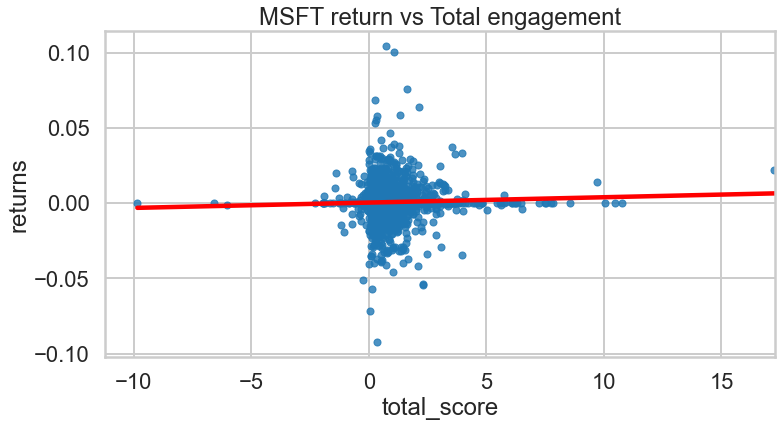

In [ ]:
#Visualize relationship between stock return and total score
sns.regplot(x='total_score', y="returns", data=Microsoft_visual_group, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("MSFT return vs Total engagement")
plt.show()

In [ ]:
#Filter data for positive tweets only
Microsoft_pos = Microsoft_visual[Microsoft_visual['score'] == 'Positive']
Microsoft_pos.head()

,post_date,score,total_score,returns,close_value
4,2015-01-01,Positive,3.0,0.0,46.45
5,2015-01-01,Positive,2.0,0.0,46.45
6,2015-01-01,Positive,19.0,0.0,46.45
9,2015-01-01,Positive,5.0,0.0,46.45
12,2015-01-01,Positive,0.0,0.0,46.45


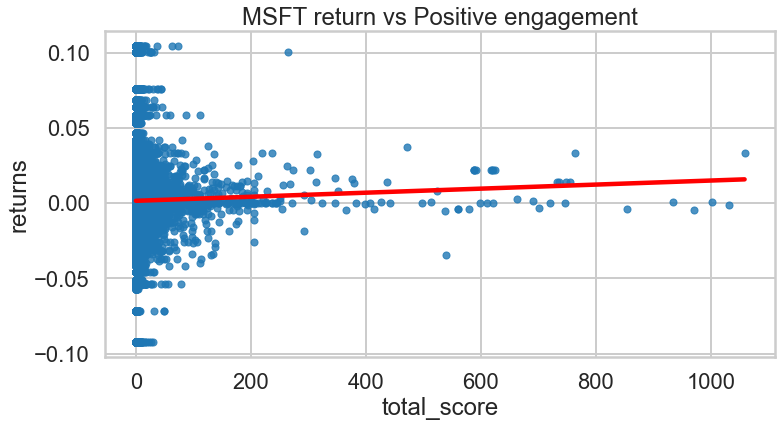

In [ ]:
#Visualize relationship between stock return and total score for positive tweets only
sns.regplot(x='total_score', y="returns", data=Microsoft_pos, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("MSFT return vs Positive engagement")
plt.show()

In [ ]:
#Filter data for negative tweets only
Microsoft_neg = Microsoft_visual[Microsoft_visual['score'] == 'Negative']
Microsoft_neg.head()

,post_date,score,total_score,returns,close_value
2,2015-01-01,Negative,-2.0,0.0,46.45
17,2015-01-01,Negative,-1.0,0.0,46.45
20,2015-01-01,Negative,-0.0,0.0,46.45
28,2015-01-01,Negative,-1.0,0.0,46.45
33,2015-01-01,Negative,-0.0,0.0,46.45


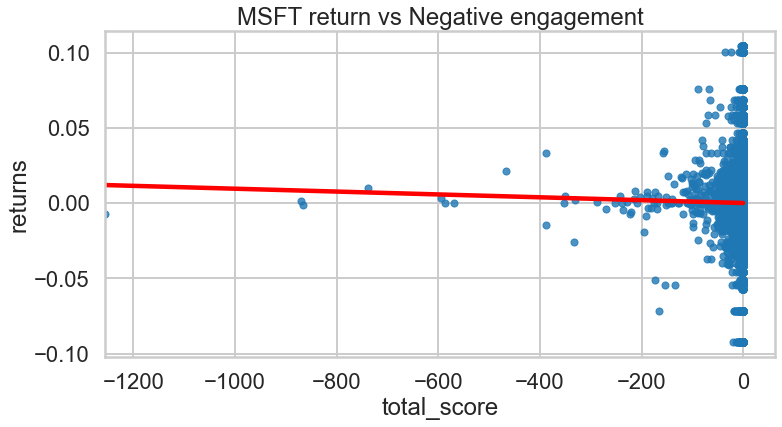

In [ ]:
#Visualize relationship between stock return and total score for negative tweets only
sns.regplot(x='total_score', y="returns", data=Microsoft_neg, ci=None, x_jitter=.05, scatter_kws={"s": 50},line_kws={'color':'red'})
plt.title("MSFT return vs Negative engagement")
plt.show()

In [ ]:
Total_pos_tweets = Microsoft_pos.groupby('post_date').mean('total_score')
Total_pos_tweets.head()

,total_score,returns,close_value
post_date,,,
2015-01-01,1.826087,0.000000,46.450
2015-01-02,0.843137,0.006674,46.760
2015-01-03,0.520000,0.000000,46.760
2015-01-04,0.333333,0.000000,46.760
2015-01-05,2.486486,-0.009303,46.325


In [ ]:
Total_neg_tweets = Microsoft_neg.groupby('post_date').mean('total_score')
Total_neg_tweets.head()

,total_score,returns,close_value
post_date,,,
2015-01-01,-0.625000,0.000000,46.450
2015-01-02,-0.470588,0.006674,46.760
2015-01-03,-0.666667,0.000000,46.760
2015-01-04,-1.000000,0.000000,46.760
2015-01-05,-1.100000,-0.009303,46.325


<ipython-input-18-06cce44a873d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Microsoft_returns['returns'] = Microsoft_returns['returns'].apply(lambda returns: returns*50)


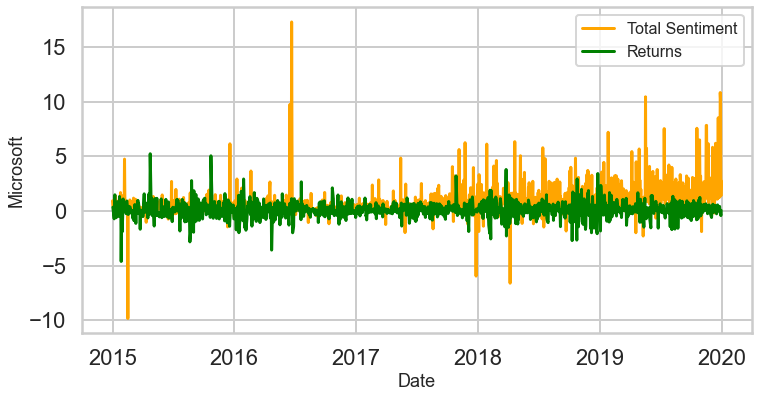

In [ ]:
#Visualize stock return and total score of sentiment per day.
Microsoft_returns = Microsoft_visual_group[Microsoft_visual_group['returns'] != 0]
Microsoft_returns['returns'] = Microsoft_returns['returns'].apply(lambda returns: returns*50)
plt.xlabel("Date" , fontsize = 18)
plt.ylabel("Microsoft", fontsize = 18)

sns.lineplot(
data = Microsoft_posneg,
        x = 'post_date',
        y = 'total_score', 
        color = 'orange'
    )
sns.lineplot(
data = Microsoft_returns,
        x = 'post_date',
        y = 'returns', 
        color = 'green'
    )
#"Positive Sentiment", "Negative Sentiment",
plt.legend(labels=["Total Sentiment", "Returns"],fontsize = 16)